# 下载数据

In [4]:
!gdown --id '1OlSAVpo1k7__G4ToTSVMWrnNZIIPRe1E'
# 列出目前目錄下所有的檔案
!ls


Downloading...
From: https://drive.google.com/uc?id=1OlSAVpo1k7__G4ToTSVMWrnNZIIPRe1E
To: /content/data.zip
239MB [00:03, 78.9MB/s]
data.zip  sample_data


In [5]:
!unzip -q "data.zip" -d "./"

# 读取数据

In [ ]:
import pandas as pd
train_data = pd.read_csv('./train/05-17.csv')
test_data = pd.read_csv('./train/05-18.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
import gc
import pandas as pd 
import numpy as np

#导入分析库
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report
import lightgbm as lgb
import xgboost as xgb
!pip install catboost
import catboost as cat

from sklearn.metrics import roc_auc_score, roc_curve, auc
# LOCAL_QUICK = True
LOCAL_QUICK = False
sample_percent = 0.1

MORE_FE = False
# MORE_FE = True
FE_V1 = False if MORE_FE else True


In [ ]:
train_data.info()

In [ ]:
#test_data = pd.read_csv('./phm_test.csv')

# 文件内存优化

In [ ]:
import numpy as np
def reduce_mem(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('{:.2f} Mb, {:.2f} Mb ({:.2f} %)'.format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    #gc.collect()
    return df

In [ ]:
test_data = reduce_mem(test_data)
train_data = reduce_mem(train_data)

186.79 Mb, 67.00 Mb (64.13 %)
186.84 Mb, 67.02 Mb (64.13 %)


列名

In [ ]:
train_data.columns = ['time', 'gun_no','W_Error','C_Cylinder_force','C_Differential_pressure','W_Friction','W_Maximum_aperture','W_Maximum_electrode_force',
            'W_Start_friction','W_us2','W_Welding_point_count',' W_position_count','area','in_Counterbalance_pressure','in_Electrode_force','in_Electrode_position','in_Sheet_thickness',
            'in_Velocity','in_force_build_up','out_Cap_offset','out_Electrode_force','out_Electrode_position','out_force_build_up']

In [ ]:
test_data.columns = ['time', 'gun_no','W_Error','C_Cylinder_force','C_Differential_pressure','W_Friction','W_Maximum_aperture','W_Maximum_electrode_force',
            'W_Start_friction','W_us2','W_Welding_point_count',' W_position_count','area','in_Counterbalance_pressure','in_Electrode_force','in_Electrode_position','in_Sheet_thickness',
            'in_Velocity','in_force_build_up','out_Cap_offset','out_Electrode_force','out_Electrode_position','out_force_build_up']

In [ ]:
train_data.info()

In [ ]:
train_data.head()

In [ ]:
#查看缺失值的情况
j = 0
for i in range(len(cols)):
  absent_gender_num = train_data.shape[0]-train_data[cols[i]].count()#gender的缺失值个数，
  abssent_gender_rate = absent_gender_num/train_data.shape[0]# 缺失率
  print(absent_gender_num,abssent_gender_rate)
  j+=1
print(j)
#无缺失值

In [ ]:
train_data['gun_no'].unique()

array(['6015660-3105', '5509057-3052', '5495029-1006', '5495066-1016',
       '5507537-1010', '5495044-3041', '5509057-3050', '5507551-1007',
       '5535608-3003', '5506559-1010', '5495066-1011'], dtype=object)

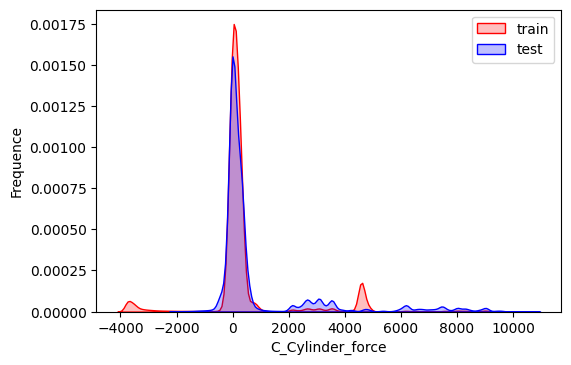

In [ ]:
plt.figure(figsize=(6,4),dpi=100)#dpi：缩放
ax = sns.kdeplot(train_data['C_Cylinder_force'], color='Red', shade=True)
ax = sns.kdeplot(test_data['C_Cylinder_force'], color='Blue', shade=True)
ax.set_xlabel('C_Cylinder_force')
ax.set_ylabel('Frequence')
ax = ax.legend(['train','test'])

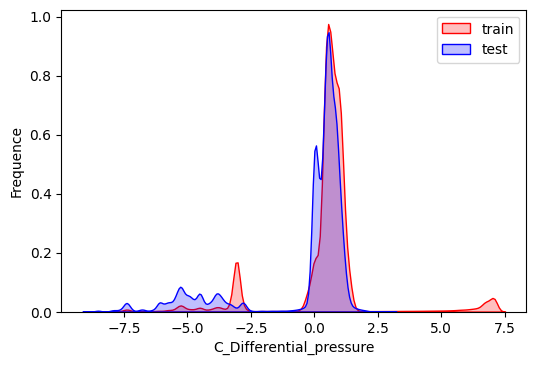

In [ ]:
plt.figure(figsize=(6,4),dpi=100)#dpi：缩放
ax = sns.kdeplot(train_data['C_Differential_pressure'], color='Red', shade=True)
ax = sns.kdeplot(test_data['C_Differential_pressure'], color='Blue', shade=True)
ax.set_xlabel('C_Differential_pressure')
ax.set_ylabel('Frequence')
ax = ax.legend(['train','test'])


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


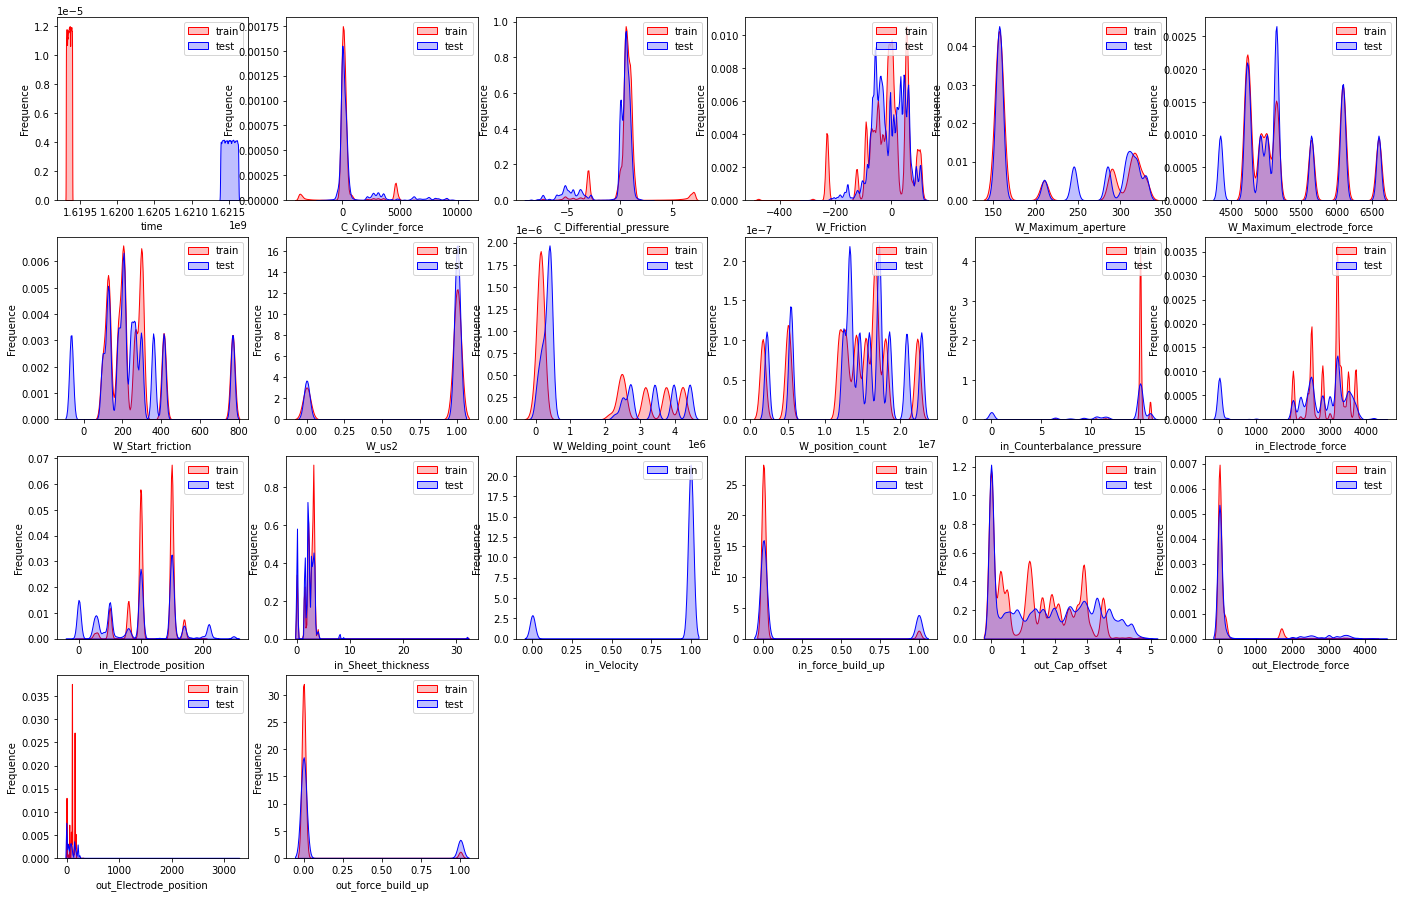

In [ ]:
train_data_noobj = train_data.drop(['gun_no','area'],axis=1)
test_data_noobj = test_data.drop(['gun_no','area'],axis=1)
dist_col = 6
dist_row = len(test_data_noobj.columns)
plt.figure(figsize=(4*dist_col, 4*dist_row))
i=1
for col in test_data_noobj.columns:
  ax = plt.subplot(dist_row,dist_col,i)
  ax = sns.kdeplot(train_data_noobj[col], color='Red', shade=True)
  ax = sns.kdeplot(test_data_noobj[col], color='Blue', shade=True)
  ax.set_xlabel(col)
  ax.set_ylabel('Frequence')
  ax = ax.legend(['train','test'])
  i+=1
plt.show()

In [ ]:
train_data.columns

Index(['time', 'gun_no', 'W_Error', 'C_Cylinder_force',
       'C_Differential_pressure', 'W_Friction', 'W_Maximum_aperture',
       'W_Maximum_electrode_force', 'W_Start_friction', 'W_us2',
       'W_Welding_point_count', ' W_position_count', 'area',
       'in_Counterbalance_pressure', 'in_Electrode_force',
       'in_Electrode_position', 'in_Sheet_thickness', 'in_Velocity',
       'in_force_build_up', 'out_Cap_offset', 'out_Electrode_force',
       'out_Electrode_position', 'out_force_build_up'],
      dtype='object')

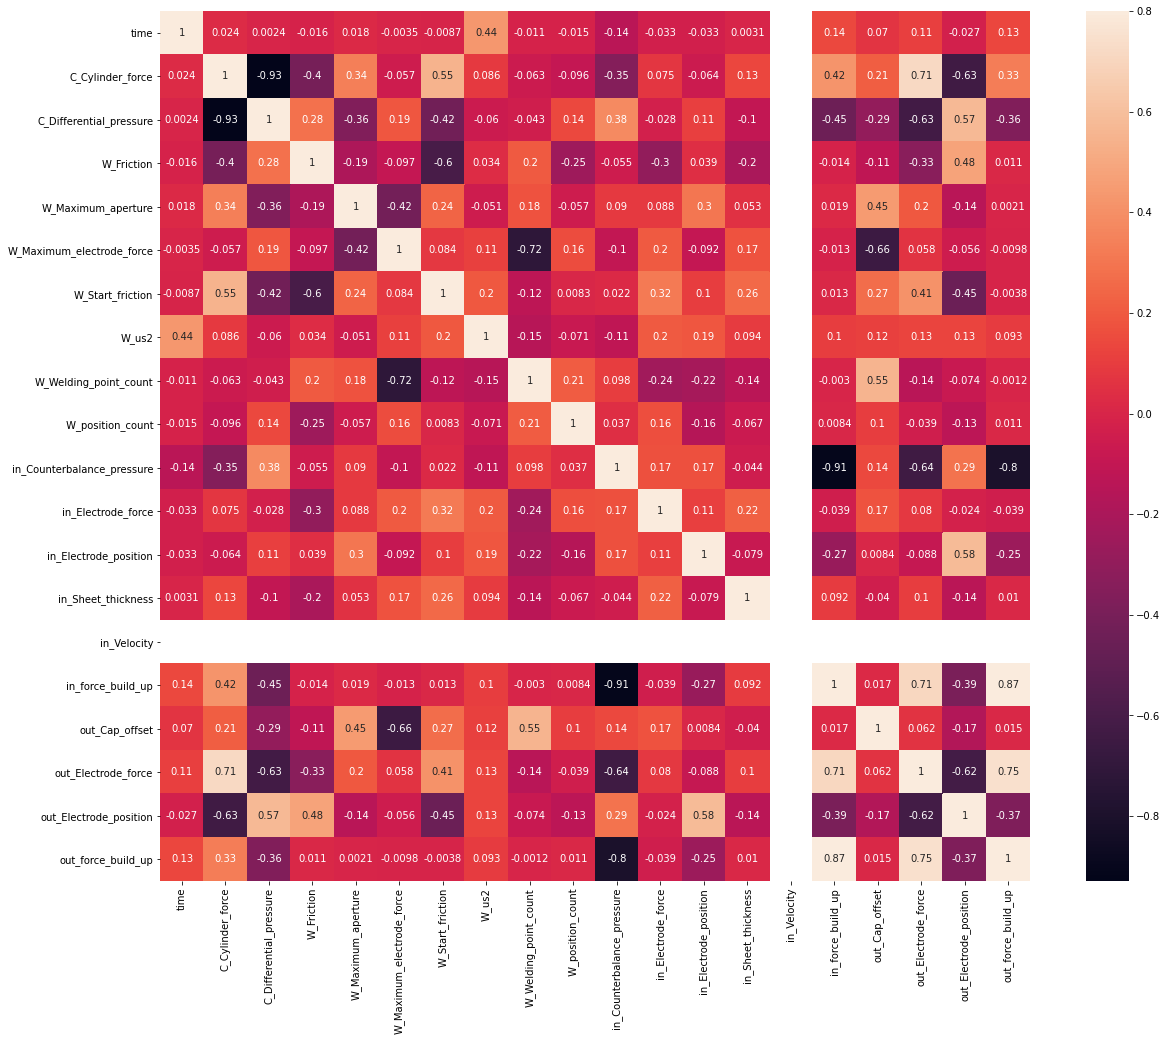

In [ ]:
import seaborn as sns
corr = train_data.corr()
corr
#画出热力图
ax = plt.subplots(figsize = (20,16))
ax = sns.heatmap(corr,vmax=.8,square=True, annot=True)


In [ ]:
pos=len(train_data[train_data['W_Error']==0])
neg = len(train_data[train_data['W_Error']==1])
print(pos,neg)

873449 698


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


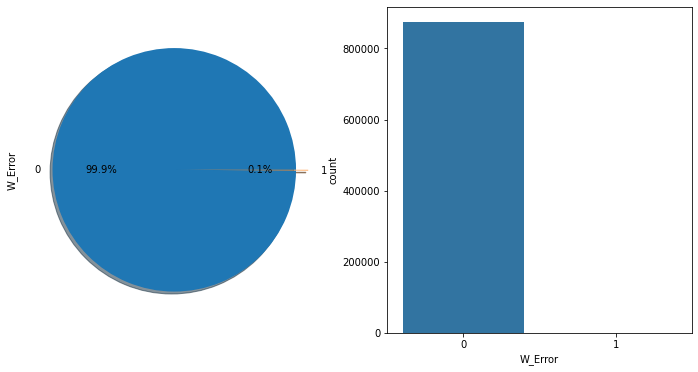

In [ ]:
_,axe = plt.subplots(1,2,figsize=(12,6))
train_data['W_Error'].value_counts().plot(kind='pie',autopct='%1.1f%%',shadow=True,explode=[0,0.1],ax=axe[0])
sns.countplot('W_Error',data=train_data,ax=axe[1])

In [ ]:
print(train_data['W_Error'].unique())

pos=len(train_data[train_data['W_Error']==0])
neg = len(train_data[train_data['W_Error']==1])
print(pos,neg)

[0 '0' 'E016' 'E003' 'E009' 'E029']
841379 0


In [ ]:
train_data['gun_no'].unique()

array(['6015660-3105', '5509057-3052', '5495029-1006', '5495066-1016',
       '5507537-1010', '5495044-3041', '5509057-3050', '5507551-1007',
       '5535608-3003', '5506559-1010', '5495066-1011'], dtype=object)

将所有故障代码标为1，焊枪标签转为0-12

In [12]:
def str2int(dt):
    errordata=dt['W_Error']
    errordata[errordata=='0']=0
    errordata[errordata!=0]=1
    errordata.replace(1,1,inplace=True)
    gunnum=dt['gun_no']
    gunval=pd.get_dummies(gunnum).columns
    for i in range(len(gunval)):
        gunnum.replace(gunval[i],i,inplace=True)
    return dt

In [11]:
def ses_str2int(dt):

    gunnum=dt['gun_no']
    gunval=pd.get_dummies(gunnum).columns
    for i in range(len(gunval)):
        gunnum.replace(gunval[i],i,inplace=True)
    return dt

In [ ]:
train_data = str2int(train_data)
test_data = str2int(test_data)

In [ ]:
print(train_data['W_Error'].unique())
print(train_data['gun_no'].unique())

[0 1]
[ 7  8 11  5 10  0  3  1  2  6 12  4  9]


In [ ]:
train_label = train_data['W_Error']
train_data = train_data.drop('W_Error',axis=1)

test_label = test_data['W_Error']
test_data = test_data.drop('W_Error',axis=1)
print(train_data.shape)
print(train_label.shape)

(1064778, 22)
(1064778,)


In [ ]:
print(train_data.columns)

Index(['time', 'gun_no', 'W_Error', 'C_Cylinder_force',
       'C_Differential_pressure', 'W_Friction', 'W_Maximum_aperture',
       'W_Maximum_electrode_force', 'W_Start_friction', 'W_us2',
       'W_Welding_point_count', ' W_position_count', 'area',
       'in_Counterbalance_pressure', 'in_Electrode_force',
       'in_Electrode_position', 'in_Sheet_thickness', 'in_Velocity',
       'in_force_build_up', 'out_Cap_offset', 'out_Electrode_force',
       'out_Electrode_position', 'out_force_build_up'],
      dtype='object')


In [ ]:
print(train_data.head())

         time  gun_no  ...  out_Electrode_position  out_force_build_up
0  1619308800      10  ...                    -1.7                   0
1  1619308800       8  ...                   110.6                   0
2  1619308800       0  ...                   152.5                   0
3  1619308800       3  ...                    -4.6                   0
4  1619308800       5  ...                   100.0                   0

[5 rows x 23 columns]


In [ ]:
drop_columns = ['time', 'gun_no','area','W_Friction','W_Welding_point_count','in_Velocity','out_Electrode_position','out_force_build_up','out_Cap_offset']
train_data.drop(drop_columns, axis=1, inplace=True)
test_data.drop(drop_columns, axis=1, inplace=True)

In [ ]:
train_data.columns.shape
test_data.columns.shape

(13,)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_label, test_size=.2, random_state=0,shuffle=False) # test_size=.3

In [ ]:
%%time
import lightgbm as lgb
import xgboost as xgb
def xgb_train(X_train, y_train, X_valid, y_valid, verbose=True):
    model_xgb = xgb.XGBClassifier(
        max_depth=10, # raw8
        n_estimators=1000,
        min_child_weight=300, 
        colsample_bytree=0.8, 
        subsample=0.8, 
        eta=0.3,    
        seed=42        
    )

    model_xgb.fit(
        X_train, 
        y_train,
        eval_metric='auc',
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=verbose,
        early_stopping_rounds=10 # 早停法，如果auc在10epoch没有进步就stop
    )
    print(model_xgb.best_score)
    return model_xgb

CPU times: user 20 µs, sys: 0 ns, total: 20 µs
Wall time: 26.5 µs


In [ ]:
xgb = xgb_train(X_train,y_train,X_valid,y_valid, verbose=False)

In [ ]:
result = xgb.predict(test_data)
import csv
with open('result.csv',"w")as targetFile:
  target_writer = csv.writer(targetFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  for i in range(len(result)):
    target_writer.writerow([result[i]])

In [ ]:
from sklearn.metrics import precision_score, recall_score

def f2_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    print(precision, recall)
    f2_score = 5 * precision * recall / (4 * precision + recall)
    return f2_score

In [ ]:
score = f2_score(test_label.values,result)
print(score)

0.9890561903943638 0.8879257980851741
0.9064628528682231


In [ ]:
j=0
for i in range(0,len(result)):
  if result[i]== test_label[i]:
    j+=1
print(j/len(result))

0.9881228839512853


In [ ]:
ses_data = pd.read_csv('phm_test.csv')

In [8]:
ses_data.columns = ['time', 'gun_no','C_Cylinder_force','C_Differential_pressure','W_Friction','W_Maximum_aperture','W_Maximum_electrode_force',
            'W_Start_friction','W_us2','W_Welding_point_count',' W_position_count','area','in_Counterbalance_pressure','in_Electrode_force','in_Electrode_position','in_Sheet_thickness',
            'in_Velocity','in_force_build_up','out_Cap_offset','out_Electrode_force','out_Electrode_position','out_force_build_up']

In [2]:
ses_data.shape

NameError: ignored

In [12]:
ses_data = ses_str2int(ses_data)
drop_columns = ['time', 'gun_no','area','W_Friction','W_Welding_point_count','in_Velocity','out_Electrode_position','out_force_build_up','out_Cap_offset']
ses_data = ses_data.drop(drop_columns,axis=1)

In [13]:
ses_data.shape

(2999999, 13)

In [1]:
import pickle
xgb_model_loaded = pickle.load(open("/content/xgb.pkl", "rb"))


FileNotFoundError: ignored

In [ ]:
ses_result = xgb_model_loaded.predict(ses_data)
import csv
with open('result.csv',"w")as targetFile:
  target_writer = csv.writer(targetFile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  for i in range(len(ses_result)):
    target_writer.writerow([ses_result[i]])

In [ ]:
tijiao = pd.read_csv('result.csv')
tijiao.shape

(2999998, 1)

In [ ]:
tijiao.columns=['value']

In [ ]:
a = tijiao['value']==1
print(a.sum())

192103


#特征融合

In [ ]:
#特征构造函数
def feature_make(train_data1, test_data1, func_dict, col_list):
  train_data1, test_data1 = train_data.copy(), test_data.copy()
  for col_i in col_list:
    for col_j in col_list:
      for func_name,func in func_dict.items():
        for data in [train_data1, test_data1]:
          func_feature = func(data[col_i],data[col_j])
          col_func_feature = '-'.join([col_i, func_name, col_j])
          data[col_func_feature] = func_feature

  return train_data1, test_data1

In [ ]:
#定义特征构造方法
eposilon = 1e-5
#组交叉特征，可以自行定义，如：x*x/y,log(x)/y等等
func_dict = {
  'add':lambda x,y:x+y,
  'mins':lambda x,y:x-y,
  'div':lambda x,y:x/(y+eposilon),
  'multi':lambda x,y:x*y
}

train_data2, test_data2 = feature_make(train_data, test_data, func_dict, col_list=test_data.columns)

In [ ]:
#特征降维处理
from sklearn.decomposition import PCA#主成分分析法
pca = PCA(n_components = 500)
train_data2_pca = pca.fit_transform(train_data2.iloc[:,0:-1])
test_data2_pca = pca.transform(test_data2)

train_data2_pca = pd.DataFrame(train_data2_pca)
test_data2_pca = pd.DataFrame(test_data2_pca)
train_data2_pca['target'] = train_data2['target']

X_train = train_data2[test_data2.columns].values
y_train = train_data2['target']

#合并文件

In [ ]:
Folder_Path = r'/content/train' 
os.chdir(Folder_Path)
file_list = os.listdir()
file_list.sort(reverse = False)
print(file_list)

['04-25.csv', '04-26.csv', '04-27.csv', '04-28.csv', '04-29.csv', '04-30.csv', '05-01.csv', '05-02.csv', '05-03.csv', '05-04.csv', '05-05.csv', '05-06.csv', '05-07.csv', '05-08.csv', '05-09.csv', '05-10.csv', '05-11.csv', '05-12.csv', '05-13.csv', '05-14.csv', '05-15.csv', '05-16.csv', '05-17.csv', '05-18.csv']


In [ ]:
import os
Folder_Path = '/content/train'          #要拼接的文件夹及其完整路径，注意不要包含中文
SaveFile_Path = '/content/connact_file'      #拼接后要保存的文件路径
SaveFile_Name = '/connact_data.csv'     #合并后要保存的文件名
 
#修改当前工作目录
#os.chdir(Folder_Path)
#将该文件夹下的所有文件名存入一个列表
#file_list = os.listdir()
 
#读取第一个CSV文件并包含表头
#df = pd.read_csv(Folder_Path +'\\'+ file_list[0])   #编码默认UTF-8，若乱码自行更改
 
#将读取的第一个CSV文件写入合并后的文件保存
#df.to_csv(SaveFile_Path+'\\'+ SaveFile_Name,encoding="utf_8_sig",index=False)
 
#循环遍历列表中各个CSV文件名，并追加到合并后的文件
for i in range(0,len(file_list)):
    df = pd.read_csv(Folder_Path + '/'+ file_list[i])
    df.to_csv(SaveFile_Path+'/'+ SaveFile_Name,encoding="utf_8_sig",index=False, header=False, mode='a+')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
data = pd.read_csv('/content/connact_file/connact_data.csv')

In [ ]:
data.columns

Index(['1619308800', '6015660-3105', '0', '185', '0.05', '-73', '290.0',
       '4763', '300', '0.1', '3150576', '16619255', 'F2', '15.99054', '3700',
       '80.0', '3.0', '1', '0.2', '2.7', '0.3', '-1.7', '0.4'],
      dtype='object')

In [ ]:
data.columns = ['time', 'gun_no','W_Error','C_Cylinder_force','C_Differential_pressure','W_Friction','W_Maximum_aperture','W_Maximum_electrode_force',
            'W_Start_friction','W_us2','W_Welding_point_count',' W_position_count','area','in_Counterbalance_pressure','in_Electrode_force','in_Electrode_position','in_Sheet_thickness',
            'in_Velocity','in_force_build_up','out_Cap_offset','out_Electrode_force','out_Electrode_position','out_force_build_up']

In [ ]:
train_data = str2int(train_data)

In [ ]:
drop_columns = ['time', 'gun_no','area','W_Friction','W_Welding_point_count','in_Velocity','out_Electrode_position','out_force_build_up','out_Cap_offset']
data.drop(drop_columns, axis=1, inplace=True)


In [ ]:
data.shape

(22491083, 14)

In [ ]:
data_label = data['W_Error']

In [ ]:
data.drop('W_Error',axis=1)

In [ ]:
#xgb 模型训练

In [4]:
import numpy as np
import pandas as pd
test = pd.read_csv('/content/phm_test.csv')

In [7]:
test.columns = ['time', 'gun_no','C_Cylinder_force','C_Differential_pressure','W_Friction','W_Maximum_aperture','W_Maximum_electrode_force',
            'W_Start_friction','W_us2','W_Welding_point_count',' W_position_count','area','in_Counterbalance_pressure','in_Electrode_force','in_Electrode_position','in_Sheet_thickness',
            'in_Velocity','in_force_build_up','out_Cap_offset','out_Electrode_force','out_Electrode_position','out_force_build_up']

In [ ]:
test = s

In [15]:
test = ses_str2int(test)

In [16]:
print(test['gun_no'].values)

[ 8  8  8 ... 10  2  8]


# 刘鑫

In [ ]:
#补充‘1’的代码
error_res = res1[res1['label']==1]
print(len(error_res))
print(error_res['label'].index)
num = 0
for i in error_res['label'].index:
    num += 1
    if num%500==0:
        print(num)
    time = res1.iloc[i,0]
    gun_no = res1.iloc[i,1]
    res1['label'][(res1['time']>time-600) & (res1['time']<time) & (res1['gun_no']==gun_no)]=1

In [6]:
import pandas as pd
first = pd.read_csv('./train/04-25.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
